In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import click
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display
import ipywidgets as widgets
import seaborn as sns

from keras.models import Model, load_model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from cnn_audio.params import pr
from cnn_audio import model_training as mt

from pathlib import Path

import click
import joblib
import librosa
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# %matplotlib inline

# Parameters

In [3]:
model_selection = {
    'pitch_detection': {
        'aim': 'Pitch Detection',
        'features': ['chroma', 'mfcc'],
        'targets': ['pitch'],
        'target_label': 'Pitch',
    },
    'instrument_type_detection': {
        'aim': 'Instrument Type Detection',
        'features': ['mfcc'],
        'targets': ['instrument_family_str'],
        'target_label': 'Instrument Type',
    },
}

In [4]:
model_selection_w = widgets.Dropdown(
    options=model_selection.keys(),
    disabled=False,
    description='Model goal:'
)
display(model_selection_w)

Dropdown(description='Model goal:', options=('pitch_detection', 'instrument_type_detection'), value='pitch_det…

In [5]:
data_size_w = widgets.Dropdown(
    options=['SAMPLE', 'FULL'],
    disabled=False,
    rows=2,
    description='Data size:'
)
display(data_size_w)

Dropdown(description='Data size:', options=('SAMPLE', 'FULL'), value='SAMPLE')

In [6]:
weights_base_dir = Path('./model/weights/')
run_id_w = widgets.Dropdown(
    options=[x.stem for x in list(weights_base_dir.glob('*'))],
    disabled=False,
    rows=2,
    description='Model run id:'
)
display(run_id_w)

Dropdown(description='Model run id:', options=('20230725_234755_f-chroma-mfcc_t-pitch', '20230726_231936_f-chr…

In [82]:
selected_model = model_selection[model_selection_w.value]  # type: ignore
aim = selected_model['aim']
features = selected_model['features']
targets = selected_model['targets']
target_label = selected_model['target_label']

data_size = data_size_w.value
run_id = run_id_w.value

midi_mapping_file = Path('./data/midi_pitch_mapping.csv')

# Preparations

In [91]:
DATA_SHAPE = (50, 94, len(features))
VALUE_COUNT = 50 * 94 * len(features)

def parse_tfrecord(example_proto):
    # TODO: find a way to get these dynamically (and efficiently!) for the parsing function
    data_shape: tuple[int, ...] = DATA_SHAPE  # (50, 94, 1)
    value_count = VALUE_COUNT  # 4700  # data_shape[0] * data_shape[1] * data_shape[2]

    feature_description = {
        'input': tf.io.FixedLenFeature([value_count], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    parsed_example['input'] = tf.reshape(parsed_example['input'], data_shape)

    input_feature = parsed_example['input']
    label_feature = parsed_example['label']

    return input_feature, label_feature

In [83]:
features_affix = '-'.join(['f'] + features)
targets_affix = '-'.join(['t'] + targets)

In [84]:
labels_file = Path(f'data/features_{data_size}/labels_{targets_affix}.joblib')
encoder: LabelEncoder = joblib.load(labels_file)

In [85]:
midi_pitch_mapping = pd.read_csv(midi_mapping_file, dtype='object')
midi_pitch_mapping['midi_pitch_int'] = midi_pitch_mapping['midi_pitch'].astype('int')
midi_pitch_mapping['note'] = midi_pitch_mapping['note'].str.replace('b', '♭') 
midi_pitch_mapping = midi_pitch_mapping.rename(columns={'note': 'midi_note_str'})
midi_pitch_order = midi_pitch_mapping['midi_note_str'].to_list()

In [86]:
weights_dir = Path(f'model/weights/{run_id}')
# find the weights file with min val_loss
weights_file = min(weights_dir.glob('*'), key=lambda x: float(x.stem[-6:]))
print(weights_file)
model: Model = load_model(weights_file)  # type: ignore

model\weights\20230727_235156_f-mfcc_t-instrument_family_str\weights_epoch-002_acc-0.65_loss-1.4064.hdf5


# Training data facts

In [87]:
training_data_path = Path('data/nsynth-train/examples.json')
td = pd.read_json(training_data_path, orient='index')

In [88]:
td_ = td.merge(midi_pitch_mapping, left_on='pitch', right_on='midi_pitch_int', how='left')
td_['midi_note_str'] = pd.Categorical(td_['midi_note_str'], categories=midi_pitch_order)

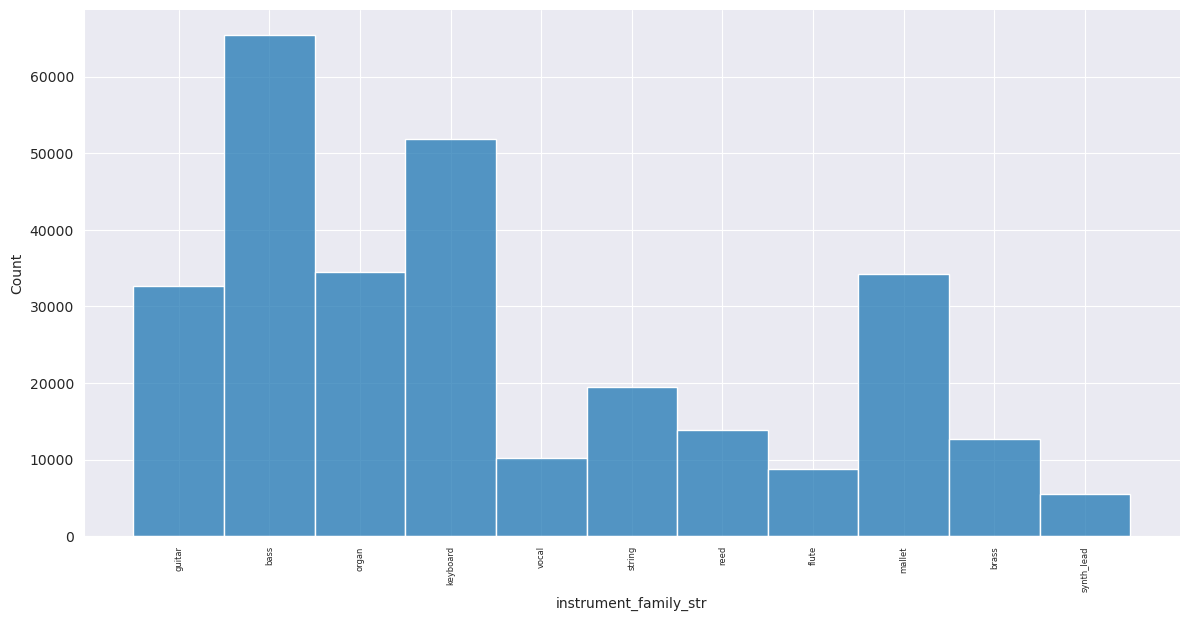

In [90]:
x_plot = 'midi_note_str' if targets == ['pitch'] else targets[0]
hue = 'instrument_family_str' if targets == ['pitch'] else None

with sns.axes_style('darkgrid', rc={'font.family': 'DejaVu Sans'}):
    sns.displot(td_, x=x_plot, binwidth=1, height=6, aspect=2, hue=hue)  # type: ignore

    # Decrease the font size for xticks
    plt.xticks(fontsize=6)
    # Rotate the xticks vertical
    plt.xticks(rotation=90)

    plt.show()

# Load the test data

In [99]:
data_paths = [f'data/features_{data_size}/test_{features_affix}_{targets_affix}.tfrecord']
test_data = tf.data.TFRecordDataset(data_paths)
test_data = test_data.map(parse_tfrecord)
test_data = test_data.batch(32)

# Evaluate the model on the test data

In [100]:
loss, accuracy = model.evaluate(test_data)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.2%}")

128/128 [==============================] - 1s 8ms/step - loss: 1.3575 - accuracy: 0.6506
Loss: 1.3575, Accuracy: 65.06%


In [101]:
y_pred = model.predict(test_data).argmax(axis=1)
y_true = np.array(list(test_data.map(lambda _, label: label))).flatten()

128/128 [==============================] - 1s 5ms/step


In [102]:
y_pred_labels = encoder.inverse_transform(y_pred)
y_true_labels = encoder.inverse_transform(y_true)

# Remove outliers 

In [103]:
remove_outliers = False

if remove_outliers:
    y_pred_labels_ = []
    y_true_labels_ = []
    for pl, tl in zip(y_pred_labels, y_true_labels):

        if not((int(tl) < 21) or (int(tl) > 108)):
            y_true_labels_.append(tl)
            y_pred_labels_.append(pl)
    
    y_pred_labels = np.array(y_pred_labels_)
    y_true_labels = np.array(y_true_labels_)

In [104]:
if targets == ['pitch']:

    classes_ = list(encoder.classes_)

    if remove_outliers: 
        classes = []
        for c in classes_:
            if not((int(c) < 21) or (int(c) > 108)):
                classes.append(c)
    
    else:
        classes = classes_

    sorted_labels = sorted(classes, key=lambda i: int(i))
    sorted_names = (
        pd.DataFrame({'label': sorted_labels})
        .merge(midi_pitch_mapping, left_on='label', right_on='midi_pitch', how='left')['midi_note_str']
        .to_list()
    )
else:
    sorted_labels = sorted(encoder.classes_)
    sorted_names = sorted(encoder.classes_)

# Calculate and Plot Metrics

In [105]:
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=sorted_labels)
cm

array([[548,   0,   0,  47,  91, 127,   0,   0,  13,   1,  16],
       [  0, 196,   0,   3,   8,   5,   0,  15,   0,   0,  42],
       [  0,   4, 144,   0,   0,   0,   0,  31,   1,   0,   0],
       [ 67,   0,   0, 216, 357,  10,   1,   0,   0,   1,   0],
       [  4,  14,   0,  52, 642,  41,   3,   3,   7,   0,   0],
       [  7,   0,   0,  11,  97,  86,   0,   0,   1,   0,   0],
       [  9,   6,  28,   0,   6,   6, 299,  54,  20,   7,  67],
       [  0,  75,   0,   0,   2,   0,   0, 142,  16,   0,   0],
       [  5,   4,   0,   0,   5,   0,   0,  15, 277,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   3,   0,   2,  17,   3,   0, 115]],
      dtype=int64)

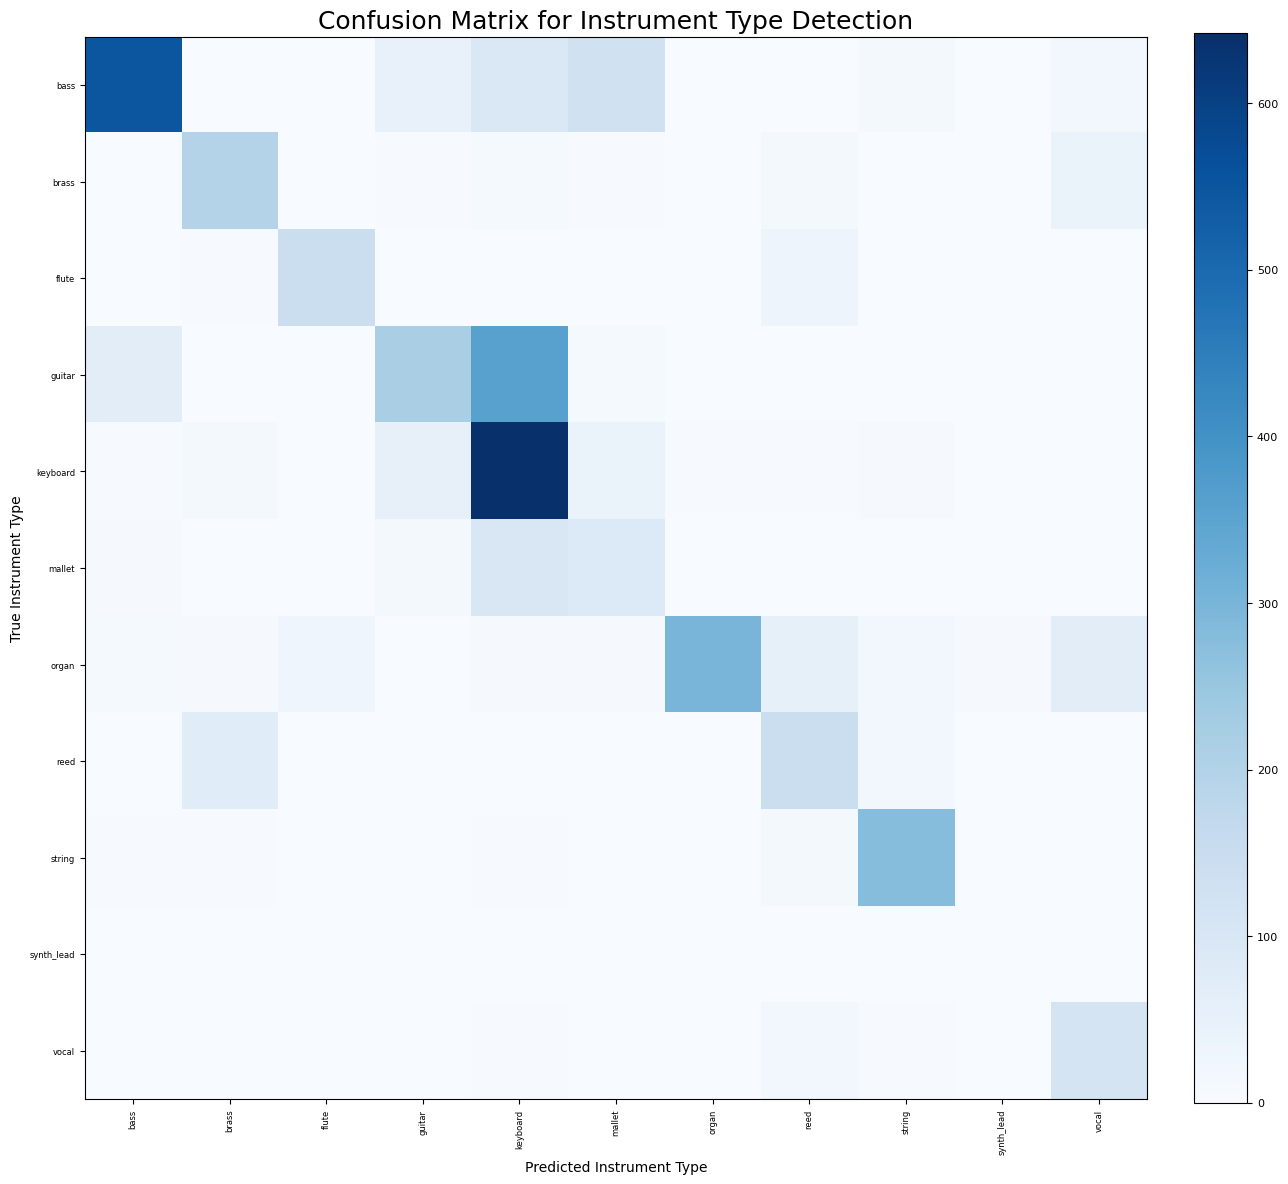

In [106]:
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()

disp = ConfusionMatrixDisplay(cm, display_labels=sorted_names)
disp.plot(include_values=False, xticks_rotation='vertical', ax=ax, colorbar=False, cmap='Blues')
# Add title and axis labels
plt.title(f'Confusion Matrix for {aim}', fontsize=18)
plt.xlabel(f'Predicted {target_label}')
plt.ylabel(f'True {target_label}')

# Decrease font size of x and y labels
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)

# Show the plot
plt.show()

In [107]:
precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)
recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

Precision: 0.7021, Recall: 0.6506


In [108]:
cr = classification_report(
    y_true_labels,
    y_pred_labels,
    labels=sorted_labels,
    target_names=sorted_names,
    zero_division=0,
    output_dict=True,
)

# Create a context manager to set the float formatting
with pd.option_context('display.float_format', '{:.4f}'.format, 'display.max_rows', 20):
    cr_df = pd.DataFrame(cr)
    df_transposed = cr_df.transpose()
    df_transposed['support'] = df_transposed['support'].astype(int)
    
    display(df_transposed)

,precision,recall,f1-score,support
bass,0.8549,0.6501,0.7385,843
brass,0.6555,0.7286,0.6901,269
flute,0.8372,0.8000,0.8182,180
guitar,0.6565,0.3313,0.4404,652
keyboard,0.5301,0.8381,0.6495,766
mallet,0.3127,0.4257,0.3606,202
organ,0.9803,0.5956,0.7410,502
reed,0.5126,0.6043,0.5547,235
string,0.8195,0.9052,0.8602,306
synth_lead,0.0000,0.0000,0.0000,0


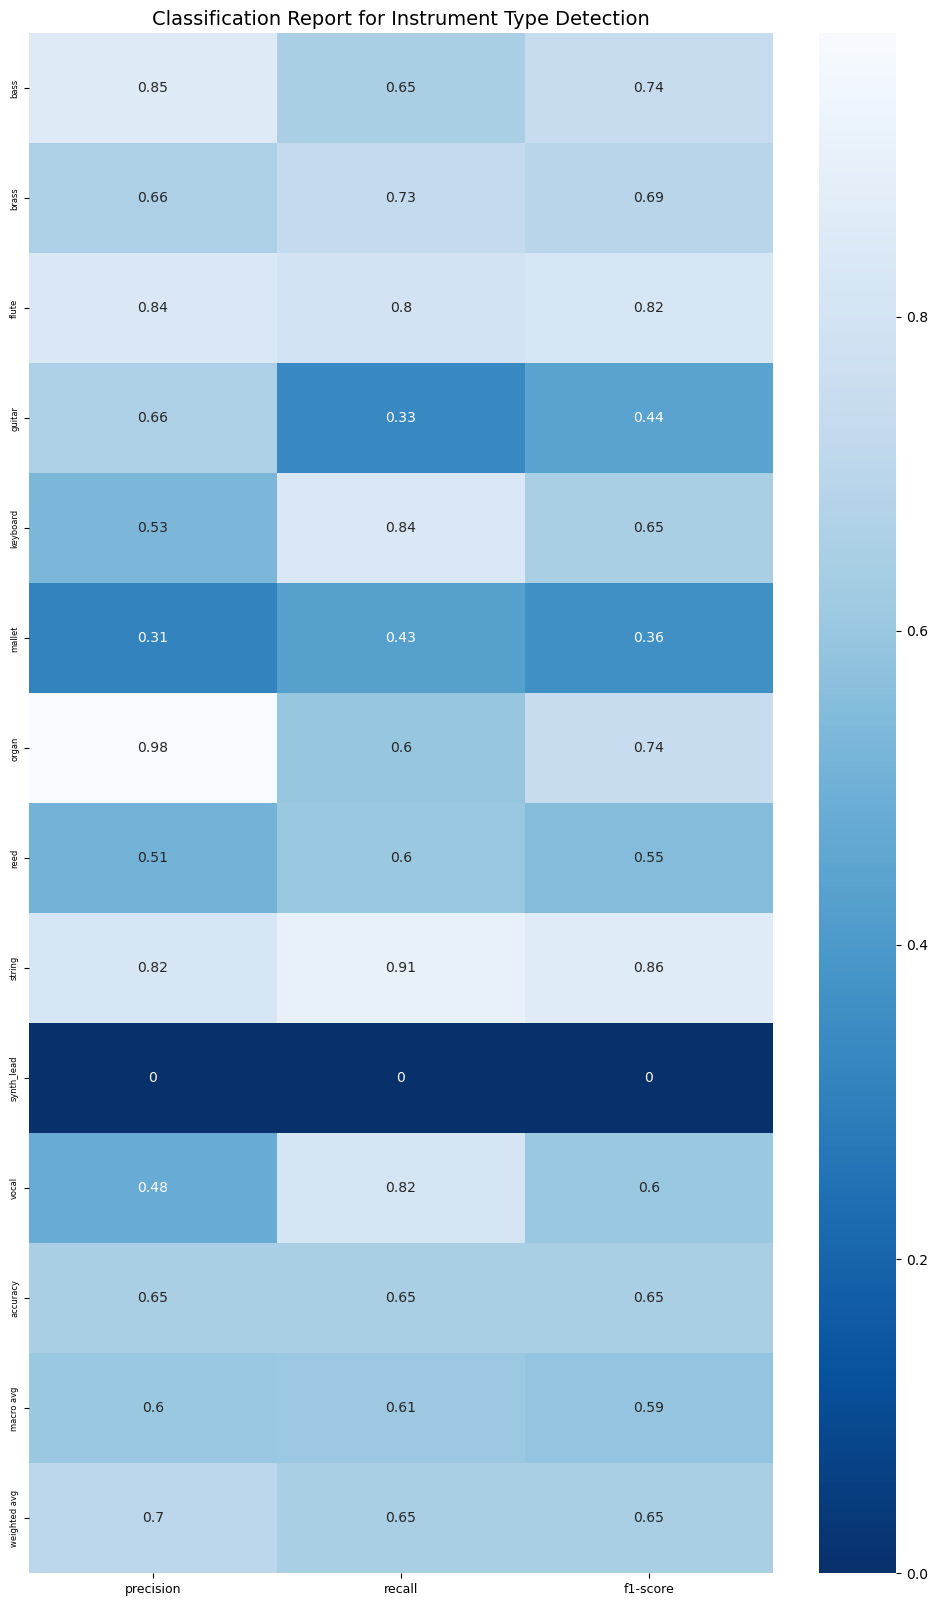

In [109]:
fig = plt.figure(figsize=(12, 20))
ax = fig.gca()

sns.heatmap(cr_df.iloc[:-1, :].T, annot=True, cmap='Blues_r', ax=ax, yticklabels=1)  # type: ignore

plt.title(f'Classification Report for {aim}', fontsize=14)

# Decrease font size of x and y labels
plt.xticks(fontsize=9)
plt.yticks(fontsize=6)

plt.show()